### **Final try**

In [ ]:
!pip install wfdb
!pip install neurokit2

In [ ]:
!pip install tqdm

In [ ]:
import os
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
from scipy.stats import iqr, skew, kurtosis, entropy
from scipy.signal import welch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
base_dir = '/content/drive/MyDrive/AFib_Capstone/mit-bih-afdb/Patient records'

all_data = []

In [ ]:
# ================================
# 🧠 3. Functions for Feature Extraction
# ================================
from scipy.signal import welch
from scipy import stats


def compute_hrv_advanced(rr_intervals):
    features = {}
    if len(rr_intervals) < 20:
        features['LF'] = np.nan
        features['HF'] = np.nan
        features['LF_HF'] = np.nan
        features['Entropy_HR'] = np.nan
        features['Median_HR'] = np.nan
        features['Skewness_HR'] = np.nan
        features['Kurtosis_HR'] = np.nan
        features['IQR_HR'] = np.nan
        features['SDRR'] = np.nan
        features['pNN50'] = np.nan
        features['pNN20'] = np.nan
        features['HRV_Triangular_Index'] = np.nan
    else:
        # Correct Power Spectral Density
        fxx, pxx = welch(rr_intervals, fs=4.0, nperseg=min(256, len(rr_intervals)))

        lf_band = (fxx >= 0.04) & (fxx <= 0.15)
        hf_band = (fxx > 0.15) & (fxx <= 0.4)
        lf = np.trapz(pxx[lf_band], fxx[lf_band])
        hf = np.trapz(pxx[hf_band], fxx[hf_band])
        lf_hf = lf / hf if hf != 0 else np.nan

        # Heart rate derived from RR
        hr_series = 60 / rr_intervals
        entropy_hr = nk.entropy_sample(hr_series)
        median_hr = np.median(hr_series)
        skewness_hr = stats.skew(hr_series)
        kurtosis_hr = stats.kurtosis(hr_series)
        iqr_hr = np.percentile(hr_series, 75) - np.percentile(hr_series, 25)

        sdrr = np.std(rr_intervals)
        diff_rr = np.abs(np.diff(rr_intervals))
        pnn50 = np.sum(diff_rr > 0.05) / len(diff_rr)
        pnn20 = np.sum(diff_rr > 0.02) / len(diff_rr)
        hrv_triangular_index = len(rr_intervals) / (np.max(np.histogram(rr_intervals, bins='auto')[0]) + 1e-10)

        features['LF'] = lf
        features['HF'] = hf
        features['LF_HF'] = lf_hf
        features['Entropy_HR'] = entropy_hr
        features['Median_HR'] = median_hr
        features['Skewness_HR'] = skewness_hr
        features['Kurtosis_HR'] = kurtosis_hr
        features['IQR_HR'] = iqr_hr
        features['SDRR'] = sdrr
        features['pNN50'] = pnn50
        features['pNN20'] = pnn20
        features['HRV_Triangular_Index'] = hrv_triangular_index

    return features


In [ ]:
# ================================
# 🔥 4. Main Processing Loop
# ================================

# Get list of patient folders
record_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
record_folders.sort()

all_data = []

for rec_folder in tqdm(record_folders, desc="Processing patients"):
    record_path = os.path.join(base_dir, rec_folder, rec_folder)

    try:
        record = wfdb.rdrecord(record_path)
        annotation = wfdb.rdann(record_path, 'atr')
    except Exception as e:
        print(f"Error reading {rec_folder}: {e}")
        continue

    fs = record.fs
    signal = record.p_signal[:, 0]
    n_samples = len(signal)
    samples_per_segment = int(2 * 60 * fs)
    n_segments = n_samples // samples_per_segment

    try:
        _, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
        rpeak_indices = rpeaks['ECG_R_Peaks']
    except Exception as e:
        print(f"R-peak detection failed for {rec_folder}: {e}")
        continue

    for seg_idx in range(n_segments):
        start_idx = seg_idx * samples_per_segment
        end_idx = (seg_idx + 1) * samples_per_segment

        if end_idx <= start_idx:
            continue

        seg_rpeaks = rpeak_indices[(rpeak_indices >= start_idx) & (rpeak_indices < end_idx)]
        if len(seg_rpeaks) < 2:
            continue

        rr_intervals = np.diff(seg_rpeaks) / fs
        hr_series = 60 / rr_intervals

        # Basic Features
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
        stdnn = np.std(rr_intervals)
        mean_rr = np.mean(rr_intervals)
        mean_hr = np.mean(hr_series)
        std_hr = np.std(hr_series)
        min_hr = np.min(hr_series)
        max_hr = np.max(hr_series)

        # AFib Presence Detection
        af_present = 0
        in_segment = np.where((annotation.sample >= start_idx) & (annotation.sample < end_idx))[0]
        for ann_i in in_segment:
            if annotation.aux_note and len(annotation.aux_note) > ann_i:
                note = annotation.aux_note[ann_i]
                note = note.replace('\x00', '').strip().upper()
                if 'AF' in note:
                    af_present = 1
                    break

        # Advanced Features
        hrv_feats = compute_hrv_advanced(rr_intervals)

        row = {
            'patient': rec_folder,
            'segment': seg_idx,
            'segment_start_sec': int(start_idx / fs),
            'RMSSD': rmssd,
            'STDNN': stdnn,
            'MEAN_RR': mean_rr,
            'MEAN_HR': mean_hr,
            'STD_HR': std_hr,
            'MIN_HR': min_hr,
            'MAX_HR': max_hr,
            'af_present': af_present
        }
        row.update(hrv_feats)
        all_data.append(row)

Processing patients:   0%|          | 0/24 [00:00<?, ?it/s]

Error reading .ipynb_checkpoints: [Errno 2] No such file or directory: '/content/drive/MyDrive/AFib_Capstone/mit-bih-afdb/Patient records/.ipynb_checkpoints/.ipynb_checkpoints.hea'


Processing patients: 100%|██████████| 24/24 [01:40<00:00,  4.18s/it]


In [ ]:
df_all_segments = pd.DataFrame(all_data)

In [ ]:
print("\n🔎 Preview of the extracted data (First 10 rows):")
display(df_all_segments.head(10))


🔎 Preview of the extracted data (First 10 rows):


,patient,segment,segment_start_sec,RMSSD,STDNN,MEAN_RR,MEAN_HR,STD_HR,MIN_HR,MAX_HR,...,LF_HF,Entropy_HR,Median_HR,Skewness_HR,Kurtosis_HR,IQR_HR,SDRR,pNN50,pNN20,HRV_Triangular_Index
0,04015,0,0,0.244164,0.201918,0.673500,97.691181,29.962113,50.167224,192.307692,...,0.775571,"(0.5417226664213731, {'Dimension': 2, 'Delay':...",99.010979,0.556422,-0.293240,41.989342,0.201918,0.657143,0.794286,3.666667
1,04015,1,120,0.212028,0.208877,0.624398,106.749165,33.547275,49.342105,189.873418,...,3.673650,"(0.42611555232668363, {'Dimension': 2, 'Delay'...",109.489051,0.297868,-0.760747,54.866111,0.208877,0.547368,0.705263,4.152174
2,04015,2,240,2.198341,1.999093,1.105556,89.822366,34.373156,3.404448,174.418605,...,0.600615,"(0.8038127484474646, {'Dimension': 2, 'Delay':...",92.596121,-0.319276,0.098784,45.218649,1.999093,0.841121,0.906542,2.634146
3,04015,3,360,0.166365,0.178559,0.545425,121.264087,35.879277,51.546392,192.307692,...,0.991920,"(0.6075273155730014, {'Dimension': 2, 'Delay':...",121.951220,0.082188,-1.046229,63.041075,0.178559,0.633028,0.816514,3.650000
4,04015,4,480,0.204414,0.163500,0.537148,120.816023,31.791400,52.631579,197.368421,...,0.568011,"(0.8971792237248012, {'Dimension': 2, 'Delay':...",120.967742,0.120957,-0.364058,41.825203,0.163500,0.774775,0.932432,4.372549
5,04015,5,600,0.201393,0.218883,0.558206,119.985951,35.225080,34.013605,192.307692,...,1.698298,"(0.46468446776813566, {'Dimension': 2, 'Delay'...",127.118644,-0.186492,-0.936525,66.160450,0.218883,0.539906,0.732394,3.014085
6,04015,6,720,0.256753,0.187330,0.714419,89.458412,25.513963,25.125628,192.307692,...,0.672425,"(0.1429996532074196, {'Dimension': 2, 'Delay':...",79.365079,1.980544,4.318106,3.176410,0.187330,0.313253,0.421687,4.282051
7,04015,7,840,0.116879,0.107901,0.729521,85.026994,19.276909,65.789474,182.926829,...,0.866406,"(0.15675357701831583, {'Dimension': 2, 'Delay'...",78.125000,2.863838,8.675310,2.045492,0.107901,0.271605,0.345679,4.527778
8,04015,8,960,0.083064,0.068075,0.742534,81.919372,12.467266,70.422535,182.926829,...,0.598389,"(0.0414573293412415, {'Dimension': 2, 'Delay':...",79.365079,5.156620,30.818009,1.266535,0.068075,0.106250,0.156250,5.193548
9,04015,9,1080,0.100182,0.064056,0.733506,82.646786,10.221257,56.818182,168.539326,...,1.198802,"(0.182508141363952, {'Dimension': 2, 'Delay': ...",81.081081,4.960964,33.074005,1.753309,0.064056,0.105590,0.186335,4.153846


In [ ]:
# 🛟 Save the extracted DataFrame

output_path = '/content/drive/MyDrive/AFib_Capstone/final_afib_all_segments_full_features.csv'
df_all_segments.to_csv(output_path, index=False)

print(f"✅ File saved successfully at: {output_path}")


✅ File saved successfully at: /content/drive/MyDrive/AFib_Capstone/final_afib_all_segments_full_features.csv


### **Verification**

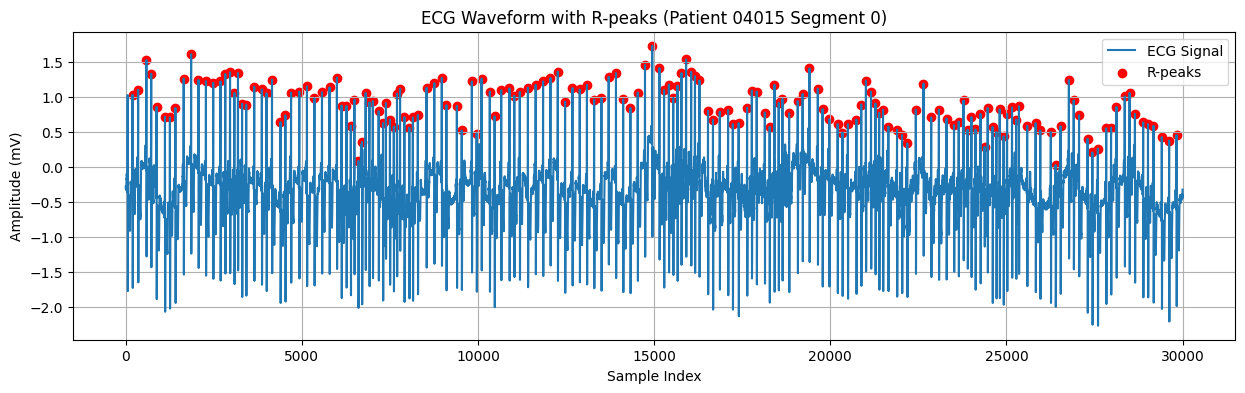

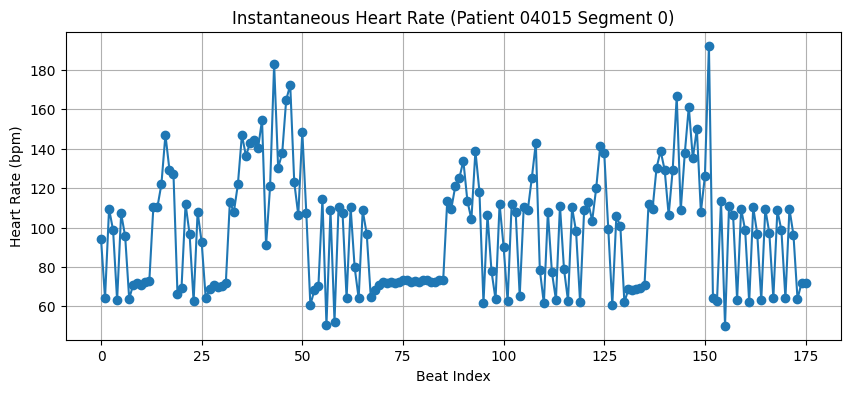

Computed mean HR: 97.69 bpm
Computed HR std: 29.96 bpm
Min HR: 50.17 bpm
Max HR: 192.31 bpm


In [ ]:
import wfdb
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the record
record_path = '/content/drive/MyDrive/AFib_Capstone/mit-bih-afdb/Patient records/04015/04015'
record = wfdb.rdrecord(record_path)
signal = record.p_signal[:, 0]  # Channel 0
fs = record.fs

# Pick Segment 0
segment_start_sec = 0
segment_duration_sec = 120  # 2 minutes
start_idx = segment_start_sec * fs
end_idx = start_idx + segment_duration_sec * fs

segment_signal = signal[start_idx:end_idx]

# Detect R-peaks
_, rpeaks = nk.ecg_peaks(segment_signal, sampling_rate=fs)
rpeaks_indices = rpeaks['ECG_R_Peaks']

# Plot ECG Signal + R-peaks
plt.figure(figsize=(15, 4))
plt.plot(segment_signal, label="ECG Signal")
plt.scatter(rpeaks_indices, segment_signal[rpeaks_indices], color='red', label="R-peaks")
plt.title("ECG Waveform with R-peaks (Patient 04015 Segment 0)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude (mV)")
plt.legend()
plt.grid()
plt.show()

# Instantaneous HR
rr_intervals = np.diff(rpeaks_indices) / fs
instant_hr = 60 / rr_intervals

plt.figure(figsize=(10,4))
plt.plot(instant_hr, marker='o')
plt.title("Instantaneous Heart Rate (Patient 04015 Segment 0)")
plt.xlabel("Beat Index")
plt.ylabel("Heart Rate (bpm)")
plt.grid()
plt.show()

# Now compare:
print(f"Computed mean HR: {np.mean(instant_hr):.2f} bpm")
print(f"Computed HR std: {np.std(instant_hr):.2f} bpm")
print(f"Min HR: {np.min(instant_hr):.2f} bpm")
print(f"Max HR: {np.max(instant_hr):.2f} bpm")


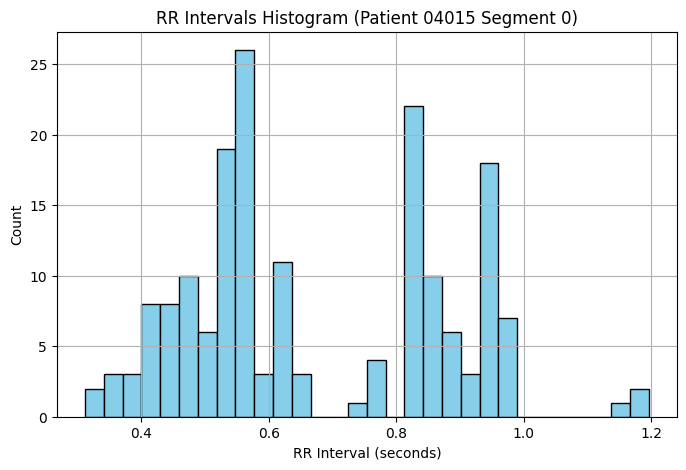

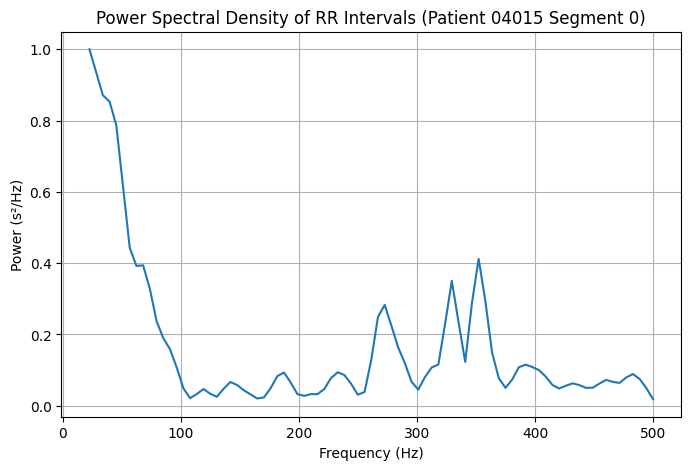

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import neurokit2 as nk

# --- Use your segment 0 RR intervals ---
# (You already have them during parsing. Let's assume you saved them here:)
# Example:
# rr_intervals_segment0 = np.diff(rpeak_indices_segment0) / fs

# If not saved earlier, detect again quickly:

record_path = '/content/drive/MyDrive/AFib_Capstone/mit-bih-afdb/Patient records/04015/04015'
record = wfdb.rdrecord(record_path)
fs = record.fs
signal = record.p_signal[:, 0]

# Detect R-peaks
_, rpeaks = nk.ecg_peaks(signal, sampling_rate=fs)
rpeak_indices = rpeaks['ECG_R_Peaks']

# For segment 0 (first 2 minutes)
start_idx = 0
end_idx = int(2 * 60 * fs)
rpeaks_segment0 = rpeak_indices[(rpeak_indices >= start_idx) & (rpeak_indices < end_idx)]
rr_intervals_segment0 = np.diff(rpeaks_segment0) / fs

# -----------------------------------
# Plot 1: Histogram of RR intervals
plt.figure(figsize=(8,5))
plt.hist(rr_intervals_segment0, bins=30, color='skyblue', edgecolor='black')
plt.title('RR Intervals Histogram (Patient 04015 Segment 0)')
plt.xlabel('RR Interval (seconds)')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# -----------------------------------
# Plot 2: Power Spectral Density of RR intervals
psd = nk.signal_psd(rr_intervals, method="welch")
fxx = psd['Frequency']
pxx = psd['Power']

plt.figure(figsize=(8,5))
plt.plot(fxx, pxx)
plt.title('Power Spectral Density of RR Intervals (Patient 04015 Segment 0)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (s²/Hz)')
plt.grid(True)
plt.show()


